# Imports

In [91]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
import torch as T
import numpy as np

# Reading

In [3]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(data_url, delimiter=';')

## Duplicates

In [4]:
df[df.duplicated()].shape[0]

240

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

In [6]:
df[df.duplicated()].shape[0]

0

## Null

In [9]:
df.isnull().values.any()

False

# First look

In [10]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5


# Info 

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1359 entries, 0 to 1358
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 127.5 KB


### Quality
noteworthy that **quality is integer**, so no rates like 3.5 or 5.78

In [12]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

# Describe

In [13]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## Notes
1. Some like chlorides are very small numbers, some like "free sulfur dioxide" are high numbers. need to normalize.
2. Quality has min 3 max 8. Not from 1 to 10 or (0-9). also it's integer.
3. Intuitively feels that quality is not linearly depend on features. (in|de)creasing one of the params would not linearly (in|de)crease the quality. So I will treat the problem as **multiclass classification**.
4. To normalize the quality we can simple minus 3 to all the values and we will have a range of 0...5 in stead of 3...8
4. Dropout thoughts. when we generalize something like used car prices it's clear than the older it is the less the price, and the more horsepowers it has the higher the price, so we use dropout a lot to make better picture on which feature influence the price more or less. When we deal with images we have only some area that is important and use dropout a lot to throw away the useless background. But in this particular case it feels like the combination of values influence quality, so I don't think that dropout is a good idea for this data.

## Notes
1. Now we have our features distributed in a range of 0...1
2. quality is now in a range of 0...5

# Correlations

<Axes: >

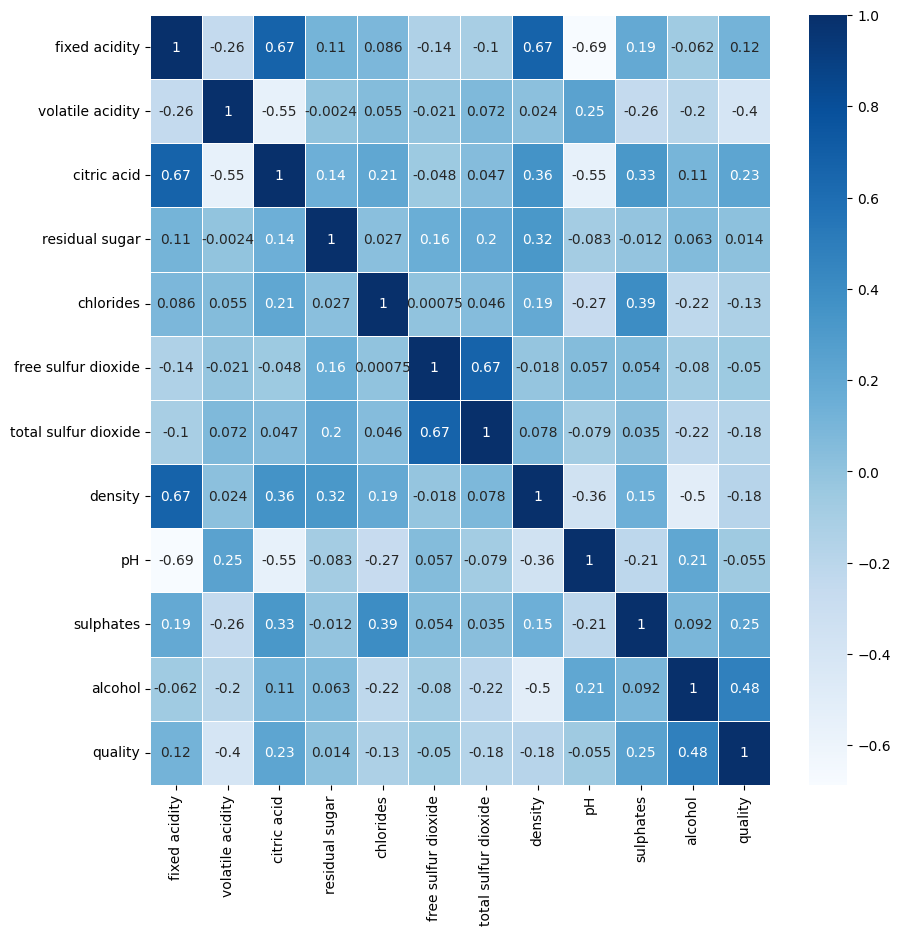

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
corr = df.corr()
sb.heatmap(corr, cmap="Blues", annot=True, linewidths=.5, ax=ax)

## Notes
1. Mostly weak correlations
2. Few high correlations (-0.69, 0.67)

# Distribution

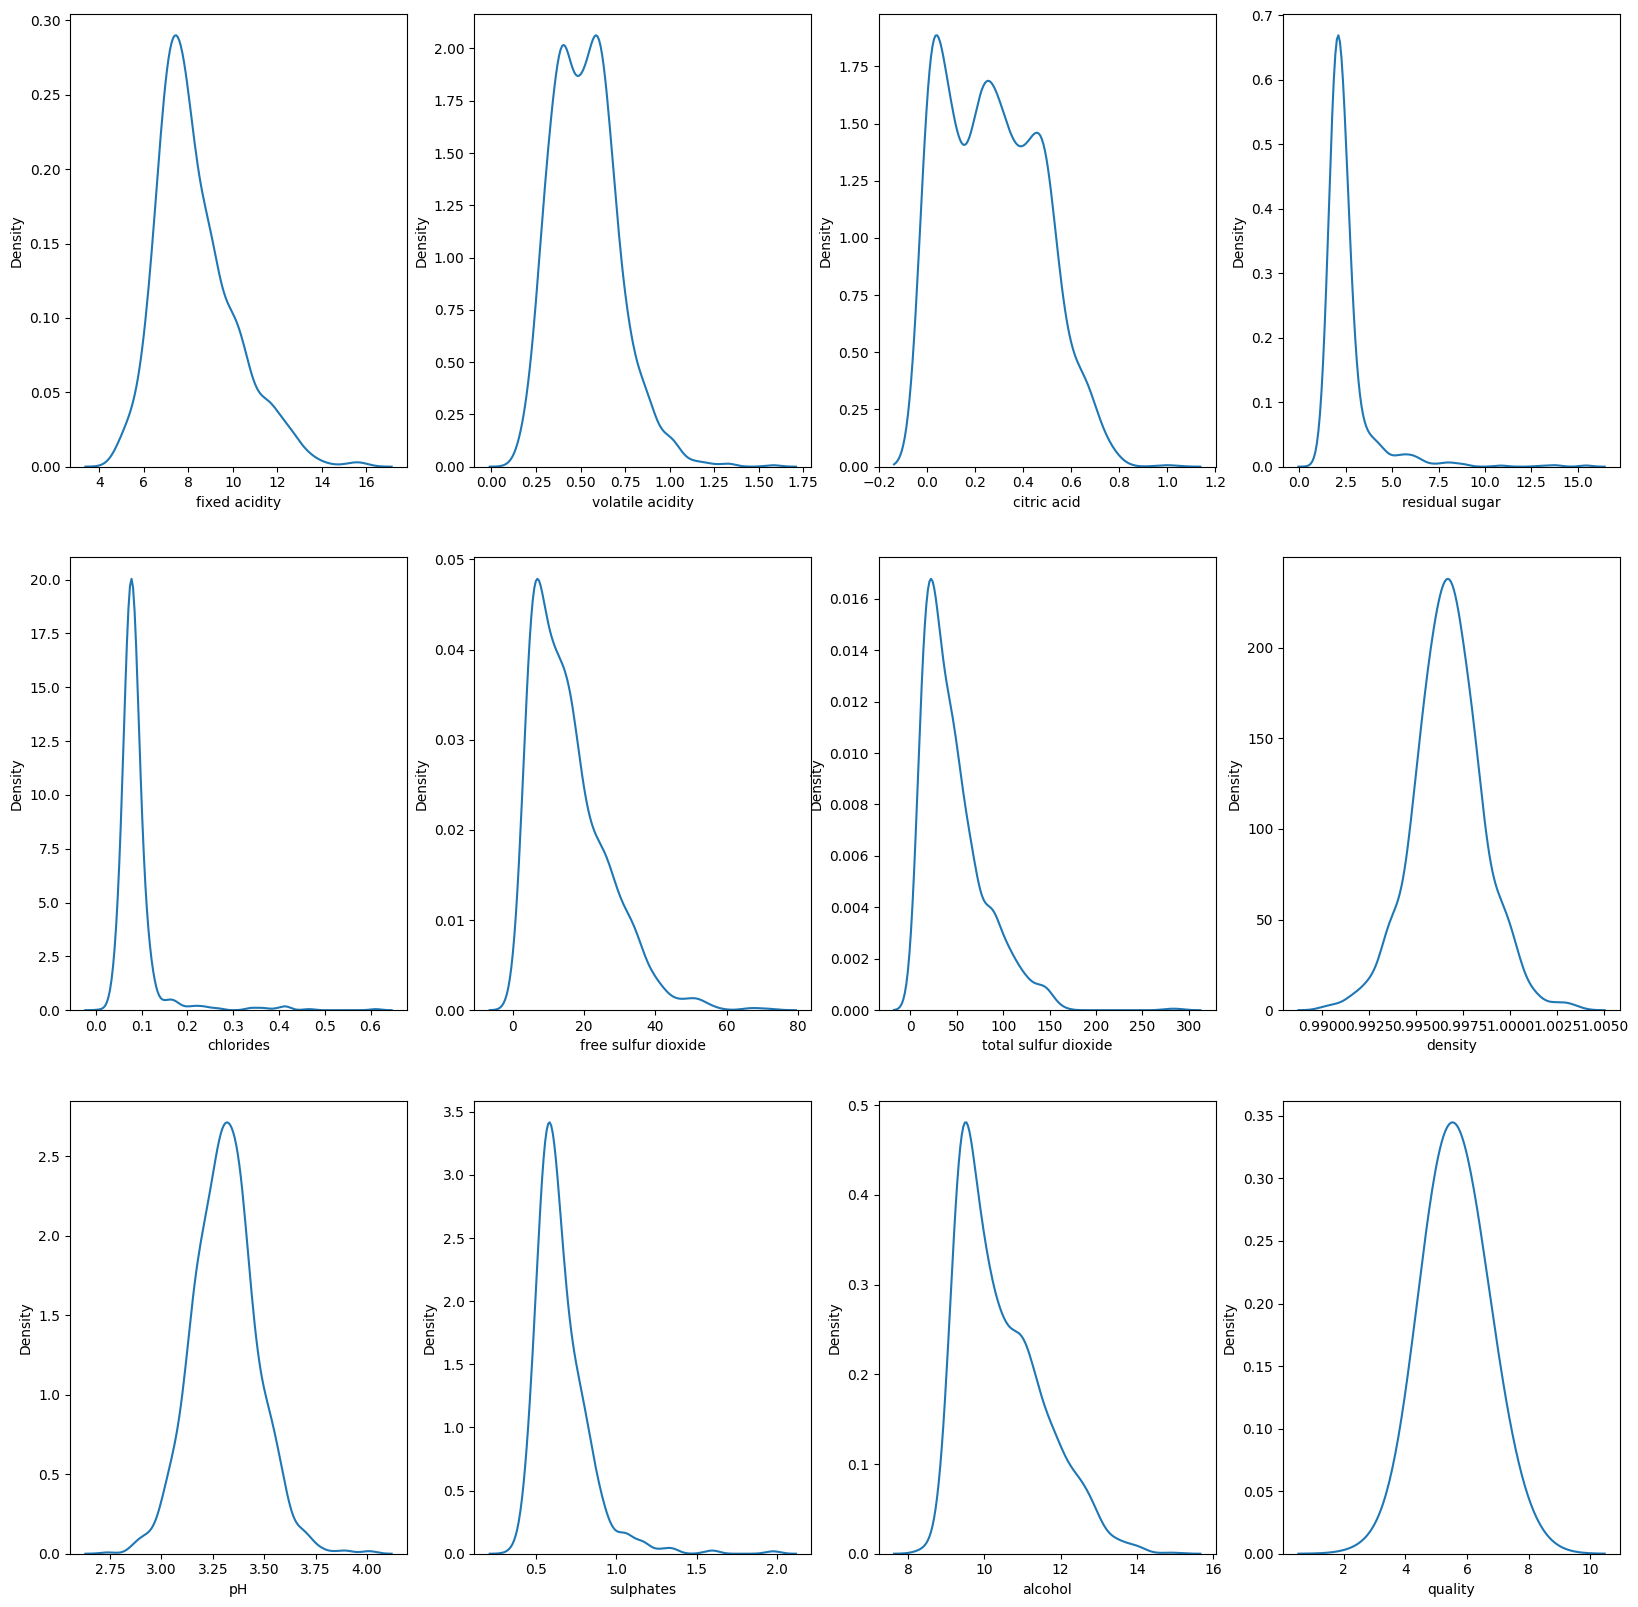

In [15]:
df_to_plot = df
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,20))

i = 0
for row in ax:
    for col in row:
        bw = 1 if df_to_plot.columns[i] == 'quality' else 'scott'
        sb.kdeplot(df_to_plot[df_to_plot.columns[i]], ax=col, bw_method=bw)
        i += 1

plt.show()

## Notes
1. we don't need to transform quality because it's our target. 
2. Density colimn looks gaussian already
3. Need to transform other data to better fit the normal distribution

In [16]:
df_to_transform = df[df.columns.difference(['quality', 'density'])]
df_to_transform.head()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity
0,9.4,0.076,0.00,7.4,11.0,3.51,1.9,0.56,34.0,0.70
1,9.8,0.098,0.00,7.8,25.0,3.20,2.6,0.68,67.0,0.88
2,9.8,0.092,0.04,7.8,15.0,3.26,2.3,0.65,54.0,0.76
3,9.8,0.075,0.56,11.2,17.0,3.16,1.9,0.58,60.0,0.28
4,9.4,0.075,0.00,7.4,13.0,3.51,1.8,0.56,40.0,0.66


In [20]:
pt = PowerTransformer(method='yeo-johnson')
data = pt.fit_transform(df_to_transform)

In [21]:
df_power_transformed = pd.DataFrame(data, columns = df_to_transform.columns)

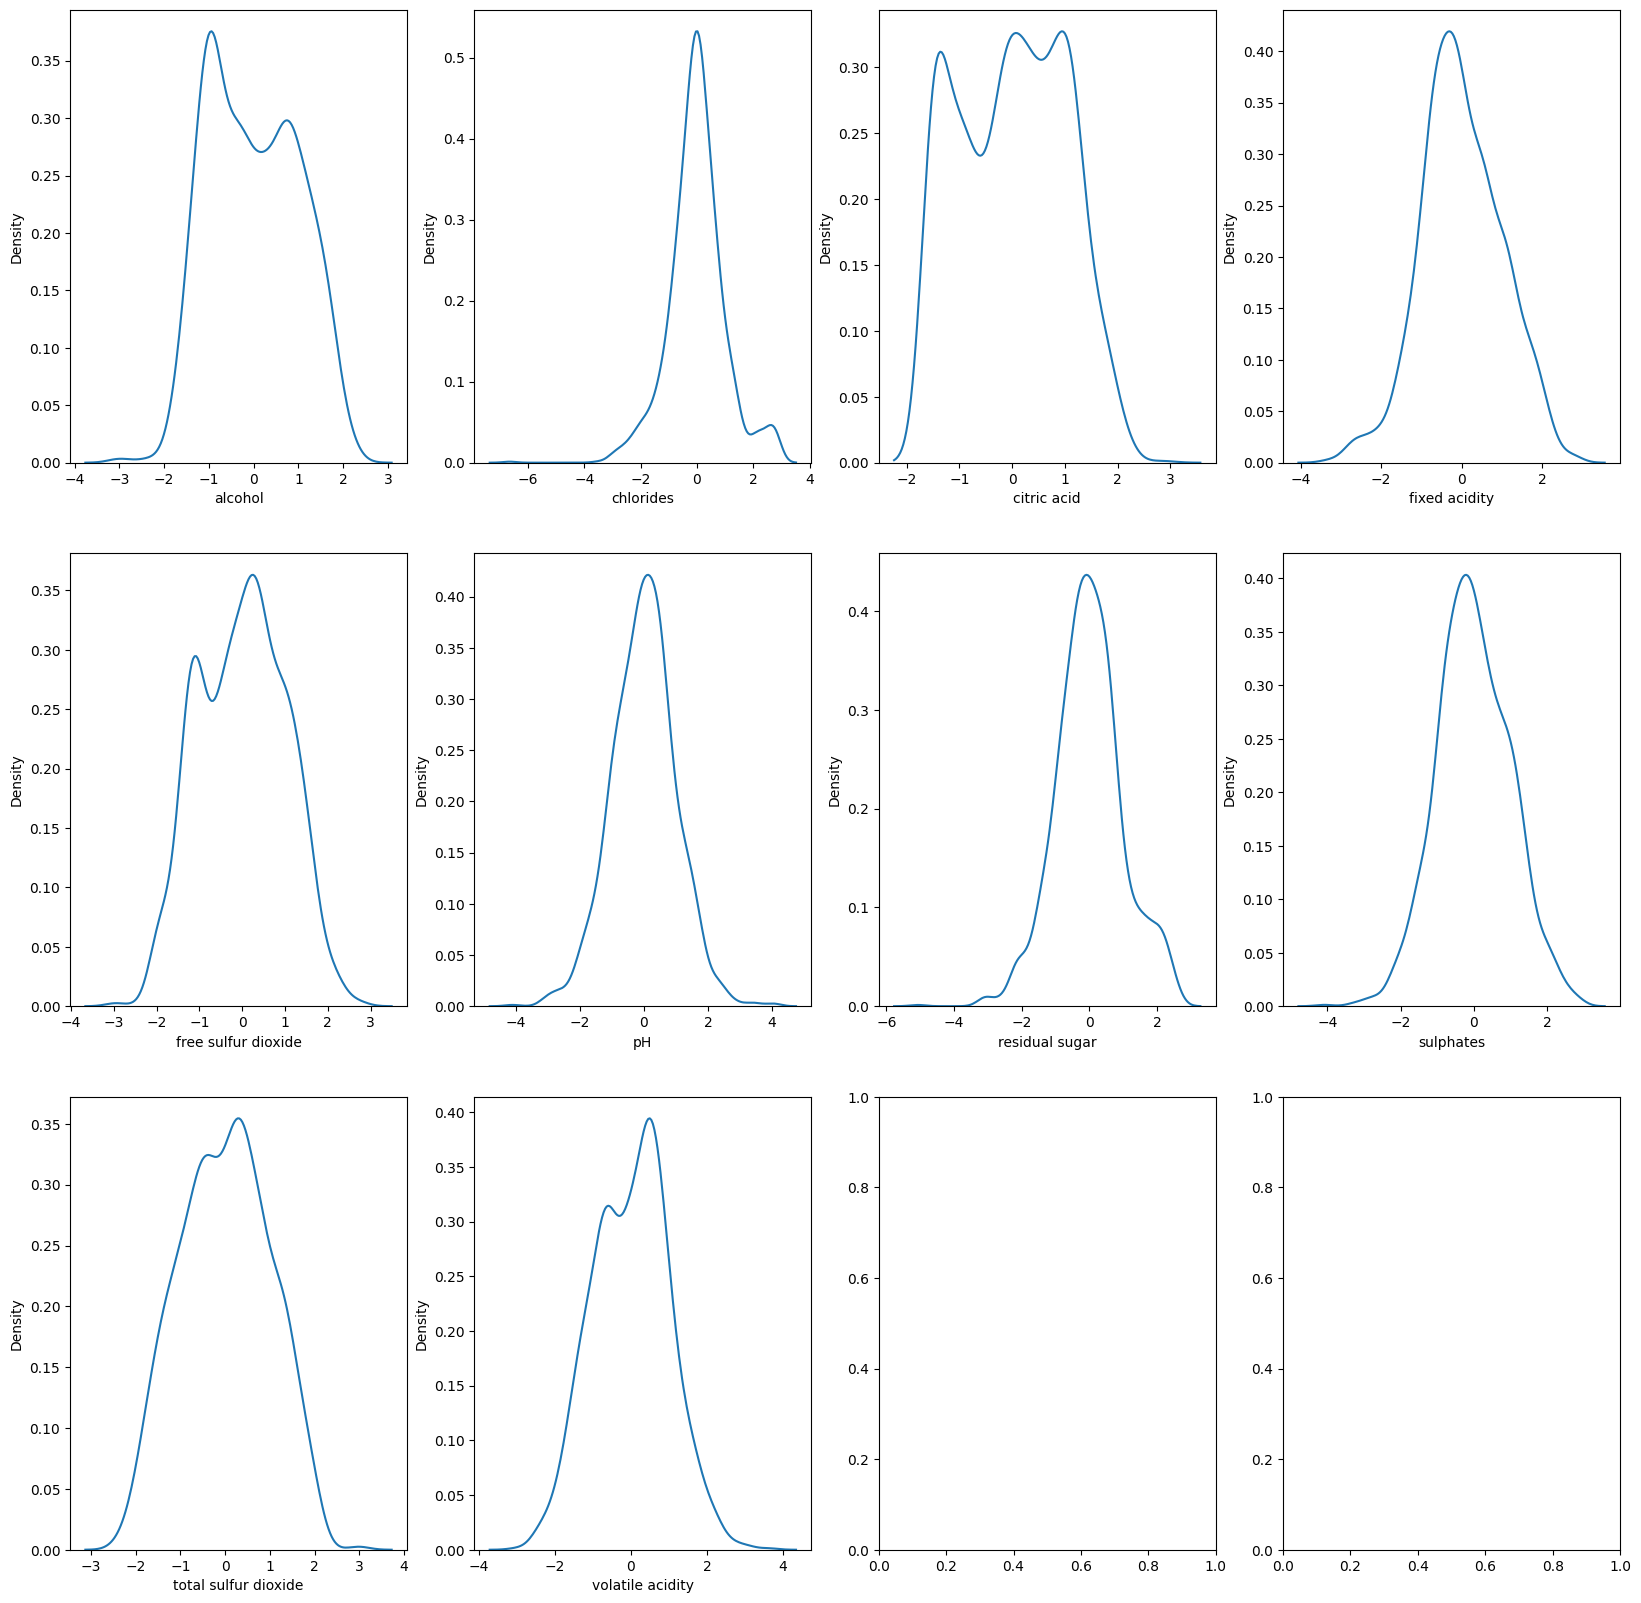

In [22]:
df_to_plot = df_power_transformed
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,20))

i = 0
for row in ax:
    for col in row:
        if i < len(df_to_plot.columns):
            sb.kdeplot(df_to_plot[df_to_plot.columns[i]], ax=col, bw_method='scott')
            i += 1

plt.show()

## Notes
1. looks not bad

Combining all together

In [23]:
df_transformed = df_power_transformed.assign(density= df['density'], quality= df['quality'])

In [24]:
df_transformed.head()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity,density,quality
0,-1.068157,-0.166676,-1.530544,-0.439412,-0.269573,1.277041,-0.602600,-0.582775,-0.128948,0.978091,0.9978,5
1,-0.499290,0.778512,-1.530544,-0.161475,0.992495,-0.695907,0.560720,0.400130,0.841796,1.720040,0.9968,5
2,-0.499290,0.557116,-1.256962,-0.161475,0.192377,-0.296058,0.153076,0.188379,0.530012,1.242047,0.9970,5
3,-0.499290,-0.219369,1.389613,1.529010,0.384096,-0.967619,-0.602600,-0.391438,0.681966,-1.551503,0.9980,6
4,-1.068157,-0.219369,-1.530544,-0.439412,-0.023152,1.277041,-0.844564,-0.582775,0.100926,0.791661,0.9978,5


In [25]:
df_transformed.describe()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity,density,quality
count,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1.359000e+03,1359.000000,1359.000000
mean,-1.202161e-12,1.673095e-16,-7.319793e-17,-3.304364e-15,-2.614212e-16,-8.114513e-15,4.601013e-15,-2.608983e-15,1.254822e-16,8.260909e-16,0.996709,5.623252
std,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,1.000368e+00,0.001869,0.823578
min,-3.052643e+00,-6.655861e+00,-1.530544e+00,-3.343948e+00,-2.954465e+00,-4.098889e+00,-5.064507e+00,-4.080089e+00,-2.418742e+00,-3.006431e+00,0.990070,3.000000
25%,-9.162483e-01,-4.979616e-01,-9.336431e-01,-6.638698e-01,-9.057037e-01,-6.286285e-01,-6.026000e-01,-6.833045e-01,-7.347551e-01,-7.432379e-01,0.995600,5.000000
50%,-2.192819e-02,-1.430324e-02,3.591066e-02,-9.548233e-02,8.796619e-02,3.028762e-02,-9.276380e-03,-4.428799e-02,2.817512e-02,6.296737e-02,0.996700,6.000000
75%,8.009605e-01,5.178146e-01,8.486054e-01,6.563056e-01,7.142441e-01,6.026136e-01,5.607201e-01,7.124374e-01,7.525495e-01,6.950817e-01,0.997820,6.000000
max,2.374067e+00,2.810993e+00,2.858594e+00,2.834418e+00,2.782969e+00,4.037677e+00,2.568209e+00,2.867367e+00,3.015701e+00,3.631274e+00,1.003690,8.000000


# Normalize
Normalization is a commone technique to make small and big numbers equally improtant

In [124]:
_df = df_transformed
normalized_df = (_df-_df.min())/(_df.max()-_df.min())
normalized_df['quality'] = _df['quality'] - 3
normalized_df['quality'] = normalized_df['quality'].astype('int32')
normalized_df.describe()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity,density,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,0.562522,0.703070,0.348712,0.541235,0.514945,0.503762,0.663526,0.587278,0.445076,0.452932,0.487441,2.623252
std,0.184342,0.105671,0.227919,0.161915,0.174358,0.122947,0.131063,0.143991,0.184079,0.150710,0.137219,0.823578
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.393681,0.650469,0.135995,0.433784,0.357087,0.426502,0.584577,0.488925,0.309873,0.340960,0.406021,2.000000
50%,0.558481,0.701559,0.356893,0.525781,0.530277,0.507484,0.662311,0.580903,0.450261,0.462419,0.486784,3.000000
75%,0.710118,0.757768,0.542054,0.647461,0.639434,0.577824,0.736989,0.689825,0.583554,0.557649,0.569016,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [126]:
normalized_df.head()

,alcohol,chlorides,citric acid,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity,density,quality
0,0.365689,0.685464,0.000000,0.470114,0.467960,0.660712,0.584577,0.503395,0.421348,0.600286,0.567548,2
1,0.470516,0.785306,0.000000,0.515100,0.687931,0.418233,0.736989,0.644872,0.599977,0.712064,0.494126,2
2,0.470516,0.761919,0.062332,0.515100,0.548476,0.467375,0.683581,0.614393,0.542605,0.640052,0.508811,2
3,0.470516,0.679898,0.665315,0.788713,0.581891,0.384839,0.584577,0.530935,0.570566,0.219191,0.582232,3
4,0.365689,0.679898,0.000000,0.470114,0.510910,0.660712,0.552876,0.503395,0.463648,0.572200,0.567548,2


# Data split, Dataset and Dataloader

In [171]:
train_cut = int(normalized_df.shape[0] * 0.7)
validation_cut = int(normalized_df.shape[0] * 0.9)
in_features = len(normalized_df.columns) - 1
out_classes = len(normalized_df['quality'].unique())

In [172]:
df_train = normalized_df[:train_cut]
df_validation = normalized_df[train_cut:validation_cut]
df_test = normalized_df[validation_cut:]
assert (df_train.shape[0] + df_validation.shape[0] + df_test.shape[0] == normalized_df.shape[0])

In [200]:
class WineDataset(Dataset):
    def __init__(self, df, in_features, out_classes):
        self.in_features = in_features
        self.out_classes = out_classes
        self.label_count = len(df['quality'].unique())
        self.array = T.tensor(df.to_numpy())

    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, idx):
        x = self.array[idx][:-1]
        label = self.array[idx, self.in_features]

        y = np.zeros(self.out_classes, dtype=np.float32)
        y[int(label.item())] = int(1)
        return x, y

In [201]:
train_dataset = WineDataset(df_train, in_features, out_classes)
train_loader = T.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=64,
)
validation_dataset = WineDataset(df_validation, in_features, out_classes)
validation_loader = T.utils.data.DataLoader(
    validation_dataset,
    shuffle=True,
    batch_size=56,
)
test_dataset = WineDataset(df_test, in_features, out_classes)
test_loader = T.utils.data.DataLoader(
    test_dataset,
    shuffle=True,
    batch_size=56,
)

In [1]:
class Net(T.nn.Module):
    def __init__(self, in_features, out_classes):
        super(Net, self).__init__()
        self.in_features = in_features
        self.out_classes = out_classes
        
        self.hid1 = T.nn.Linear(in_features, in_features * 20)
        self.b1 = T.nn.BatchNorm1d(self.in_features * 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        
        self.hid2 = T.nn.Linear(in_features * 20, in_features * 15)
        self.b2 = T.nn.BatchNorm1d(self.in_features * 15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)        
        
#         self.hid3 = T.nn.Linear(in_features * 5 , in_features*3)
#         self.b3 = T.nn.BatchNorm1d(self.in_features * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        
        
        self.oupt = T.nn.Linear(in_features * 15, out_classes)

        T.nn.init.xavier_uniform_(self.hid1.weight)
        T.nn.init.zeros_(self.hid1.bias)
        T.nn.init.xavier_uniform_(self.hid2.weight)
        T.nn.init.zeros_(self.hid2.bias)
        T.nn.init.xavier_uniform_(self.oupt.weight) 
        T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        z = T.tanh(self.hid1(x))
        z = self.b1(z)
        
        z = T.relu(self.hid2(z))
        z = self.b2(z)

#         z = T.relu(self.hid3(z))
#         z = self.b3(z)
    
    
        z = T.relu(self.oupt(z))
#         z = T.tanh(z)
        return z

NameError: name 'T' is not defined

In [2]:
# rate_learning = 1e-2
# weight_decay  = 1e-4
model = Net(in_features, out_classes)
criterion = T.nn.CrossEntropyLoss()
optimizer = T.optim.Adam(model.parameters())
df_metrics = pd.DataFrame({'train_loss': pd.Series(dtype='float'), 'validation_loss': pd.Series(dtype='float')})

NameError: name 'Net' is not defined

In [271]:
epochs = 300

def train_model(df_metrics, train_loader, validation_loader, epochs):
    for epoch in range(epochs):
        epoch_train_loss = 0
        train_correct = 0
        train_incorrect = 0        
        for x, y in train_loader:
            
            batch_size = x.shape[0]
            
#             print ('--- x,y ---')
#             print(x, y)
#             print ('--- end x,y ---')
            optimizer.zero_grad()
            yhat = model.forward(x.float())
#             print ('--- yhat ---')
#             print(yhat)
#             print ('--- end yhat ---')
            
            loss = criterion(yhat, y)
#             print ('--- loss ---')
#             print(loss)
#             print ('--- end loss ---')            
            epoch_train_loss += loss.data * batch_size
            loss.backward()
            optimizer.step()
            
            _, labelhat = torch.max(yhat, 1)
            _, label = torch.max(y, 1)
            train_correct += (labelhat == label).sum().item()
            train_incorrect += (labelhat != label).sum().item()            

#         print(epoch_train_loss)
        train_accuracy = train_correct / (train_correct + train_incorrect)
        print('Epoch: {0}, correct: {1}, incorrect: {2}, accuracy: {3}'.format(df_metrics.shape[0], train_correct, train_incorrect, train_accuracy))
        
        # Validate
        epoch_validation_loss = 0
        validation_correct = 0
        validation_incorrect = 0
        for x, y in validation_loader:
            batch_size = x.shape[0]
            yhat = model(x.float())
            loss = criterion(yhat, y)
            epoch_validation_loss += loss.data * batch_size
            
            _, labelhat = torch.max(yhat, 1)
            _, label = torch.max(y, 1)
            validation_correct += (labelhat == label).sum().item()
            validation_incorrect += (labelhat != label).sum().item()
            
        df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
        print('Epoch: {0}, loss_train: {1}, validation_loss: {2}'.format(df_metrics.shape[0], epoch_train_loss, epoch_validation_loss))
        print('Epoch: {0}, loss_train: {1}, validation_loss: {2}'.format(df_metrics.shape[0], epoch_train_loss/(train_correct + train_incorrect), epoch_validation_loss/(validation_correct + validation_incorrect)))
        validation_accuracy = validation_correct / (validation_correct + validation_incorrect)
        print('Epoch: {0}, correct: {1}, incorrect: {2}, accuracy: {3}'.format(df_metrics.shape[0], validation_correct, validation_incorrect, validation_accuracy))
        print('--')
    return df_metrics

df_metrics = train_model(df_metrics, train_loader, validation_loader, epochs)
df_metrics.head()

Epoch: 0, correct: 410, incorrect: 541, accuracy: 0.43112513144058884
Epoch: 1, loss_train: 1403.196533203125, validation_loss: 380.59576416015625
Epoch: 1, loss_train: 1.4754958152770996, validation_loss: 1.3992490768432617
Epoch: 1, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 1, correct: 530, incorrect: 421, accuracy: 0.5573080967402734
Epoch: 2, loss_train: 1207.1669921875, validation_loss: 354.24005126953125
Epoch: 2, loss_train: 1.269365906715393, validation_loss: 1.3023531436920166
Epoch: 2, correct: 151, incorrect: 121, accuracy: 0.5551470588235294
--
Epoch: 2, correct: 574, incorrect: 377, accuracy: 0.6035751840168244


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 3, loss_train: 1126.9305419921875, validation_loss: 336.66583251953125
Epoch: 3, loss_train: 1.1849952936172485, validation_loss: 1.2377420663833618
Epoch: 3, correct: 157, incorrect: 115, accuracy: 0.5772058823529411
--
Epoch: 3, correct: 573, incorrect: 378, accuracy: 0.6025236593059937
Epoch: 4, loss_train: 1095.146240234375, validation_loss: 339.1915283203125
Epoch: 4, loss_train: 1.1515733003616333, validation_loss: 1.2470276355743408
Epoch: 4, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 4, correct: 595, incorrect: 356, accuracy: 0.6256572029442692
Epoch: 5, loss_train: 1041.9388427734375, validation_loss: 320.3553466796875
Epoch: 5, loss_train: 1.0956244468688965, validation_loss: 1.1777770519256592
Epoch: 5, correct: 174, incorrect: 98, accuracy: 0.6397058823529411
--
Epoch: 5, correct: 590, incorrect: 361, accuracy: 0.6203995793901157
Epoch: 6, loss_train: 1025.8350830078125, validation_loss: 325.58489990234375
Epoch: 6, loss_train: 1.0786908864974976, valid

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 8, loss_train: 970.00830078125, validation_loss: 318.70599365234375
Epoch: 8, loss_train: 1.01998770236969, validation_loss: 1.1717132329940796
Epoch: 8, correct: 162, incorrect: 110, accuracy: 0.5955882352941176
--
Epoch: 8, correct: 605, incorrect: 346, accuracy: 0.6361724500525763
Epoch: 9, loss_train: 954.574951171875, validation_loss: 317.7852783203125
Epoch: 9, loss_train: 1.0037591457366943, validation_loss: 1.1683282852172852
Epoch: 9, correct: 166, incorrect: 106, accuracy: 0.6102941176470589
--
Epoch: 9, correct: 590, incorrect: 361, accuracy: 0.6203995793901157
Epoch: 10, loss_train: 939.475830078125, validation_loss: 318.7268371582031
Epoch: 10, loss_train: 0.9878820776939392, validation_loss: 1.1717898845672607
Epoch: 10, correct: 165, incorrect: 107, accuracy: 0.6066176470588235
--


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 10, correct: 606, incorrect: 345, accuracy: 0.637223974763407
Epoch: 11, loss_train: 918.4337158203125, validation_loss: 324.2533874511719
Epoch: 11, loss_train: 0.9657557606697083, validation_loss: 1.1921080350875854
Epoch: 11, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 11, correct: 602, incorrect: 349, accuracy: 0.6330178759200841
Epoch: 12, loss_train: 922.9979858398438, validation_loss: 317.85015869140625
Epoch: 12, loss_train: 0.9705551862716675, validation_loss: 1.1685667037963867
Epoch: 12, correct: 159, incorrect: 113, accuracy: 0.5845588235294118
--
Epoch: 12, correct: 600, incorrect: 351, accuracy: 0.6309148264984227


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 13, loss_train: 907.3890380859375, validation_loss: 316.6080322265625
Epoch: 13, loss_train: 0.9541419744491577, validation_loss: 1.164000153541565
Epoch: 13, correct: 161, incorrect: 111, accuracy: 0.5919117647058824
--
Epoch: 13, correct: 615, incorrect: 336, accuracy: 0.6466876971608833
Epoch: 14, loss_train: 907.878173828125, validation_loss: 311.42626953125
Epoch: 14, loss_train: 0.9546563625335693, validation_loss: 1.1449495553970337
Epoch: 14, correct: 160, incorrect: 112, accuracy: 0.5882352941176471
--
Epoch: 14, correct: 614, incorrect: 337, accuracy: 0.6456361724500526
Epoch: 15, loss_train: 886.2208862304688, validation_loss: 312.73370361328125
Epoch: 15, loss_train: 0.9318831562995911, validation_loss: 1.1497563123703003
Epoch: 15, correct: 163, incorrect: 109, accuracy: 0.5992647058823529
--
Epoch: 15, correct: 606, incorrect: 345, accuracy: 0.637223974763407
Epoch: 16, loss_train: 882.9832153320312, validation_loss: 309.43109130859375
Epoch: 16, loss_train: 0.9284

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 18, loss_train: 868.3683471679688, validation_loss: 332.28741455078125
Epoch: 18, loss_train: 0.9131107926368713, validation_loss: 1.2216448783874512
Epoch: 18, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 18, correct: 617, incorrect: 334, accuracy: 0.6487907465825447
Epoch: 19, loss_train: 846.51904296875, validation_loss: 318.9949951171875
Epoch: 19, loss_train: 0.8901357054710388, validation_loss: 1.1727757453918457
Epoch: 19, correct: 162, incorrect: 110, accuracy: 0.5955882352941176
--
Epoch: 19, correct: 624, incorrect: 327, accuracy: 0.6561514195583596
Epoch: 20, loss_train: 828.2957763671875, validation_loss: 310.8841247558594
Epoch: 20, loss_train: 0.8709734678268433, validation_loss: 1.1429563760757446
Epoch: 20, correct: 163, incorrect: 109, accuracy: 0.5992647058823529
--
Epoch: 20, correct: 635, incorrect: 316, accuracy: 0.6677181913774973
Epoch: 21, loss_train: 822.5648803710938, validation_loss: 315.45068359375
Epoch: 21, loss_train: 0.8649473190307617

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 23, loss_train: 806.7005615234375, validation_loss: 311.01043701171875
Epoch: 23, loss_train: 0.8482655882835388, validation_loss: 1.143420696258545
Epoch: 23, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 23, correct: 641, incorrect: 310, accuracy: 0.6740273396424816
Epoch: 24, loss_train: 803.3076171875, validation_loss: 327.2955322265625
Epoch: 24, loss_train: 0.8446978330612183, validation_loss: 1.2032923698425293
Epoch: 24, correct: 155, incorrect: 117, accuracy: 0.5698529411764706
--
Epoch: 24, correct: 637, incorrect: 314, accuracy: 0.6698212407991588
Epoch: 25, loss_train: 795.2904052734375, validation_loss: 313.20892333984375
Epoch: 25, loss_train: 0.8362675309181213, validation_loss: 1.1515034437179565
Epoch: 25, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 25, correct: 632, incorrect: 319, accuracy: 0.6645636172450052
Epoch: 26, loss_train: 798.9196166992188, validation_loss: 325.0908508300781
Epoch: 26, loss_train: 0.840

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 28, loss_train: 788.0776977539062, validation_loss: 314.81146240234375
Epoch: 28, loss_train: 0.8286831974983215, validation_loss: 1.1573951244354248
Epoch: 28, correct: 155, incorrect: 117, accuracy: 0.5698529411764706
--
Epoch: 28, correct: 634, incorrect: 317, accuracy: 0.6666666666666666
Epoch: 29, loss_train: 780.7230834960938, validation_loss: 314.391357421875
Epoch: 29, loss_train: 0.8209496140480042, validation_loss: 1.1558505296707153
Epoch: 29, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 29, correct: 653, incorrect: 298, accuracy: 0.68664563617245
Epoch: 30, loss_train: 763.0167236328125, validation_loss: 310.0186767578125
Epoch: 30, loss_train: 0.8023309111595154, validation_loss: 1.1397745609283447
Epoch: 30, correct: 160, incorrect: 112, accuracy: 0.5882352941176471
--
Epoch: 30, correct: 651, incorrect: 300, accuracy: 0.6845425867507886
Epoch: 31, loss_train: 749.7493286132812, validation_loss: 313.025634765625
Epoch: 31, loss_train: 0.788379967212677,

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 33, correct: 672, incorrect: 279, accuracy: 0.7066246056782335
Epoch: 34, loss_train: 748.596923828125, validation_loss: 313.79559326171875
Epoch: 34, loss_train: 0.7871681451797485, validation_loss: 1.1536602973937988
Epoch: 34, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 34, correct: 643, incorrect: 308, accuracy: 0.676130389064143
Epoch: 35, loss_train: 755.4601440429688, validation_loss: 308.5827331542969
Epoch: 35, loss_train: 0.7943850159645081, validation_loss: 1.1344953775405884
Epoch: 35, correct: 162, incorrect: 110, accuracy: 0.5955882352941176
--
Epoch: 35, correct: 669, incorrect: 282, accuracy: 0.7034700315457413


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 36, loss_train: 743.446533203125, validation_loss: 318.351806640625
Epoch: 36, loss_train: 0.7817524075508118, validation_loss: 1.1704111099243164
Epoch: 36, correct: 154, incorrect: 118, accuracy: 0.5661764705882353
--
Epoch: 36, correct: 655, incorrect: 296, accuracy: 0.6887486855941115
Epoch: 37, loss_train: 736.3927001953125, validation_loss: 317.1028747558594
Epoch: 37, loss_train: 0.7743351459503174, validation_loss: 1.1658194065093994
Epoch: 37, correct: 159, incorrect: 113, accuracy: 0.5845588235294118
--
Epoch: 37, correct: 686, incorrect: 265, accuracy: 0.7213459516298633
Epoch: 38, loss_train: 718.44580078125, validation_loss: 318.1575012207031
Epoch: 38, loss_train: 0.7554635405540466, validation_loss: 1.1696966886520386
Epoch: 38, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 38, correct: 681, incorrect: 270, accuracy: 0.7160883280757098
Epoch: 39, loss_train: 708.672607421875, validation_loss: 317.4388732910156
Epoch: 39, loss_train: 0.7451867461204529, 

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 41, correct: 688, incorrect: 263, accuracy: 0.7234490010515248
Epoch: 42, loss_train: 688.0960083007812, validation_loss: 315.3879699707031
Epoch: 42, loss_train: 0.7235499620437622, validation_loss: 1.1595145463943481
Epoch: 42, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 42, correct: 687, incorrect: 264, accuracy: 0.722397476340694
Epoch: 43, loss_train: 693.656982421875, validation_loss: 310.2417907714844
Epoch: 43, loss_train: 0.7293974757194519, validation_loss: 1.1405948400497437
Epoch: 43, correct: 155, incorrect: 117, accuracy: 0.5698529411764706
--
Epoch: 43, correct: 701, incorrect: 250, accuracy: 0.7371188222923238


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 44, loss_train: 680.2481689453125, validation_loss: 313.3217468261719
Epoch: 44, loss_train: 0.7152977585792542, validation_loss: 1.1519181728363037
Epoch: 44, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 44, correct: 685, incorrect: 266, accuracy: 0.7202944269190326
Epoch: 45, loss_train: 680.71728515625, validation_loss: 311.9942626953125
Epoch: 45, loss_train: 0.7157910466194153, validation_loss: 1.1470377445220947
Epoch: 45, correct: 162, incorrect: 110, accuracy: 0.5955882352941176
--
Epoch: 45, correct: 690, incorrect: 261, accuracy: 0.7255520504731862
Epoch: 46, loss_train: 684.6763305664062, validation_loss: 309.8946533203125
Epoch: 46, loss_train: 0.7199540734291077, validation_loss: 1.139318585395813
Epoch: 46, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 46, correct: 690, incorrect: 261, accuracy: 0.7255520504731862
Epoch: 47, loss_train: 667.1882934570312, validation_loss: 315.1832275390625
Epoch: 47, loss_train: 0.7015649676322937

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 49, loss_train: 641.8253173828125, validation_loss: 318.0456848144531
Epoch: 49, loss_train: 0.674895167350769, validation_loss: 1.1692856550216675
Epoch: 49, correct: 154, incorrect: 118, accuracy: 0.5661764705882353
--
Epoch: 49, correct: 708, incorrect: 243, accuracy: 0.7444794952681388
Epoch: 50, loss_train: 649.5987548828125, validation_loss: 312.944580078125
Epoch: 50, loss_train: 0.6830691695213318, validation_loss: 1.150531530380249
Epoch: 50, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 50, correct: 700, incorrect: 251, accuracy: 0.7360672975814931
Epoch: 51, loss_train: 650.3159790039062, validation_loss: 316.48394775390625
Epoch: 51, loss_train: 0.6838233470916748, validation_loss: 1.163543939590454
Epoch: 51, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 51, correct: 709, incorrect: 242, accuracy: 0.7455310199789695
Epoch: 52, loss_train: 638.0224609375, validation_loss: 313.8554382324219
Epoch: 52, loss_train: 0.6708964

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 54, correct: 703, incorrect: 248, accuracy: 0.7392218717139852
Epoch: 55, loss_train: 644.6792602539062, validation_loss: 308.3232116699219
Epoch: 55, loss_train: 0.6778962016105652, validation_loss: 1.133541226387024
Epoch: 55, correct: 158, incorrect: 114, accuracy: 0.5808823529411765
--
Epoch: 55, correct: 712, incorrect: 239, accuracy: 0.7486855941114616
Epoch: 56, loss_train: 631.000244140625, validation_loss: 323.09844970703125
Epoch: 56, loss_train: 0.6635123491287231, validation_loss: 1.1878619194030762
Epoch: 56, correct: 151, incorrect: 121, accuracy: 0.5551470588235294
--
Epoch: 56, correct: 718, incorrect: 233, accuracy: 0.7549947423764458


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 57, loss_train: 620.9575805664062, validation_loss: 303.3035888671875
Epoch: 57, loss_train: 0.652952253818512, validation_loss: 1.1150866746902466
Epoch: 57, correct: 152, incorrect: 120, accuracy: 0.5588235294117647
--
Epoch: 57, correct: 704, incorrect: 247, accuracy: 0.7402733964248159
Epoch: 58, loss_train: 630.74560546875, validation_loss: 313.5612487792969
Epoch: 58, loss_train: 0.6632446050643921, validation_loss: 1.1527986526489258
Epoch: 58, correct: 149, incorrect: 123, accuracy: 0.5477941176470589
--
Epoch: 58, correct: 721, incorrect: 230, accuracy: 0.7581493165089379


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 59, loss_train: 611.4141845703125, validation_loss: 317.84503173828125
Epoch: 59, loss_train: 0.6429170966148376, validation_loss: 1.1685478687286377
Epoch: 59, correct: 152, incorrect: 120, accuracy: 0.5588235294117647
--
Epoch: 59, correct: 731, incorrect: 220, accuracy: 0.768664563617245
Epoch: 60, loss_train: 582.1790161132812, validation_loss: 314.67578125
Epoch: 60, loss_train: 0.6121756434440613, validation_loss: 1.1568962335586548
Epoch: 60, correct: 152, incorrect: 120, accuracy: 0.5588235294117647
--
Epoch: 60, correct: 714, incorrect: 237, accuracy: 0.750788643533123
Epoch: 61, loss_train: 597.7435913085938, validation_loss: 323.4606018066406
Epoch: 61, loss_train: 0.6285421848297119, validation_loss: 1.1891933679580688
Epoch: 61, correct: 150, incorrect: 122, accuracy: 0.5514705882352942
--
Epoch: 61, correct: 731, incorrect: 220, accuracy: 0.768664563617245
Epoch: 62, loss_train: 589.2269287109375, validation_loss: 325.94024658203125
Epoch: 62, loss_train: 0.6195866

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 63, correct: 723, incorrect: 228, accuracy: 0.7602523659305994
Epoch: 64, loss_train: 577.6845703125, validation_loss: 321.22003173828125
Epoch: 64, loss_train: 0.6074495911598206, validation_loss: 1.1809560060501099
Epoch: 64, correct: 149, incorrect: 123, accuracy: 0.5477941176470589
--
Epoch: 64, correct: 719, incorrect: 232, accuracy: 0.7560462670872765
Epoch: 65, loss_train: 594.4658813476562, validation_loss: 306.5357666015625
Epoch: 65, loss_train: 0.625095546245575, validation_loss: 1.1269696950912476
Epoch: 65, correct: 157, incorrect: 115, accuracy: 0.5772058823529411
--
Epoch: 65, correct: 724, incorrect: 227, accuracy: 0.7613038906414301


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 66, loss_train: 579.3158569335938, validation_loss: 322.7529296875
Epoch: 66, loss_train: 0.6091649532318115, validation_loss: 1.186591625213623
Epoch: 66, correct: 148, incorrect: 124, accuracy: 0.5441176470588235
--
Epoch: 66, correct: 735, incorrect: 216, accuracy: 0.7728706624605678
Epoch: 67, loss_train: 566.9506225585938, validation_loss: 315.5874938964844
Epoch: 67, loss_train: 0.5961626172065735, validation_loss: 1.1602481603622437
Epoch: 67, correct: 154, incorrect: 118, accuracy: 0.5661764705882353
--
Epoch: 67, correct: 738, incorrect: 213, accuracy: 0.7760252365930599
Epoch: 68, loss_train: 580.6769409179688, validation_loss: 321.5758056640625
Epoch: 68, loss_train: 0.6105961799621582, validation_loss: 1.182263970375061
Epoch: 68, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 68, correct: 736, incorrect: 215, accuracy: 0.7739221871713985
Epoch: 69, loss_train: 570.8759765625, validation_loss: 321.4335021972656
Epoch: 69, loss_train: 0.600290179

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 71, correct: 735, incorrect: 216, accuracy: 0.7728706624605678
Epoch: 72, loss_train: 566.7227783203125, validation_loss: 320.9122314453125
Epoch: 72, loss_train: 0.5959230065345764, validation_loss: 1.1798243522644043
Epoch: 72, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 72, correct: 728, incorrect: 223, accuracy: 0.7655099894847529
Epoch: 73, loss_train: 558.0552978515625, validation_loss: 319.5345153808594
Epoch: 73, loss_train: 0.5868089199066162, validation_loss: 1.1747592687606812
Epoch: 73, correct: 149, incorrect: 123, accuracy: 0.5477941176470589
--
Epoch: 73, correct: 748, incorrect: 203, accuracy: 0.786540483701367


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 74, loss_train: 540.8876342773438, validation_loss: 315.71966552734375
Epoch: 74, loss_train: 0.5687566995620728, validation_loss: 1.1607340574264526
Epoch: 74, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 74, correct: 752, incorrect: 199, accuracy: 0.7907465825446898
Epoch: 75, loss_train: 539.81396484375, validation_loss: 324.1479797363281
Epoch: 75, loss_train: 0.5676277279853821, validation_loss: 1.1917204856872559
Epoch: 75, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 75, correct: 762, incorrect: 189, accuracy: 0.8012618296529969
Epoch: 76, loss_train: 528.3126220703125, validation_loss: 304.7597961425781
Epoch: 76, loss_train: 0.555533766746521, validation_loss: 1.1204404830932617
Epoch: 76, correct: 148, incorrect: 124, accuracy: 0.5441176470588235
--
Epoch: 76, correct: 754, incorrect: 197, accuracy: 0.7928496319663512
Epoch: 77, loss_train: 530.4744262695312, validation_loss: 321.5832824707031
Epoch: 77, loss_train: 0.557

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 79, loss_train: 523.103271484375, validation_loss: 326.2880554199219
Epoch: 79, loss_train: 0.5500560402870178, validation_loss: 1.199588418006897
Epoch: 79, correct: 155, incorrect: 117, accuracy: 0.5698529411764706
--
Epoch: 79, correct: 772, incorrect: 179, accuracy: 0.8117770767613038
Epoch: 80, loss_train: 495.4232482910156, validation_loss: 324.4647216796875
Epoch: 80, loss_train: 0.5209497809410095, validation_loss: 1.1928850412368774
Epoch: 80, correct: 151, incorrect: 121, accuracy: 0.5551470588235294
--
Epoch: 80, correct: 776, incorrect: 175, accuracy: 0.8159831756046267
Epoch: 81, loss_train: 508.3876953125, validation_loss: 332.2801513671875
Epoch: 81, loss_train: 0.5345821976661682, validation_loss: 1.2216181755065918
Epoch: 81, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 81, correct: 778, incorrect: 173, accuracy: 0.8180862250262881
Epoch: 82, loss_train: 493.926025390625, validation_loss: 327.37091064453125
Epoch: 82, loss_train: 0.519375

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 84, loss_train: 502.8559265136719, validation_loss: 343.1479797363281
Epoch: 84, loss_train: 0.5287654399871826, validation_loss: 1.2615734338760376
Epoch: 84, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 84, correct: 758, incorrect: 193, accuracy: 0.7970557308096741
Epoch: 85, loss_train: 508.85382080078125, validation_loss: 329.991943359375
Epoch: 85, loss_train: 0.535072386264801, validation_loss: 1.2132056951522827
Epoch: 85, correct: 144, incorrect: 128, accuracy: 0.5294117647058824
--
Epoch: 85, correct: 780, incorrect: 171, accuracy: 0.8201892744479495
Epoch: 86, loss_train: 492.80889892578125, validation_loss: 324.06268310546875
Epoch: 86, loss_train: 0.5182007551193237, validation_loss: 1.1914069652557373
Epoch: 86, correct: 145, incorrect: 127, accuracy: 0.5330882352941176
--
Epoch: 86, correct: 772, incorrect: 179, accuracy: 0.8117770767613038
Epoch: 87, loss_train: 500.69854736328125, validation_loss: 328.11248779296875
Epoch: 87, loss_train: 

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 89, correct: 779, incorrect: 172, accuracy: 0.8191377497371188
Epoch: 90, loss_train: 470.6036376953125, validation_loss: 332.58746337890625
Epoch: 90, loss_train: 0.49485135078430176, validation_loss: 1.222748041152954
Epoch: 90, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 90, correct: 761, incorrect: 190, accuracy: 0.8002103049421662
Epoch: 91, loss_train: 490.94488525390625, validation_loss: 341.07550048828125
Epoch: 91, loss_train: 0.516240656375885, validation_loss: 1.2539540529251099
Epoch: 91, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 91, correct: 779, incorrect: 172, accuracy: 0.8191377497371188


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 92, loss_train: 486.4975280761719, validation_loss: 328.96551513671875
Epoch: 92, loss_train: 0.5115641951560974, validation_loss: 1.2094320058822632
Epoch: 92, correct: 145, incorrect: 127, accuracy: 0.5330882352941176
--
Epoch: 92, correct: 766, incorrect: 185, accuracy: 0.8054679284963197
Epoch: 93, loss_train: 477.5744934082031, validation_loss: 320.08331298828125
Epoch: 93, loss_train: 0.5021814107894897, validation_loss: 1.1767768859863281
Epoch: 93, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 93, correct: 777, incorrect: 174, accuracy: 0.8170347003154574
Epoch: 94, loss_train: 480.33074951171875, validation_loss: 344.2278137207031
Epoch: 94, loss_train: 0.5050796270370483, validation_loss: 1.2655434608459473
Epoch: 94, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 94, correct: 779, incorrect: 172, accuracy: 0.8191377497371188
Epoch: 95, loss_train: 472.3763427734375, validation_loss: 334.00286865234375
Epoch: 95, loss_train:

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 97, correct: 788, incorrect: 163, accuracy: 0.8286014721345951
Epoch: 98, loss_train: 445.5981750488281, validation_loss: 347.7914123535156
Epoch: 98, loss_train: 0.4685575067996979, validation_loss: 1.2786449193954468
Epoch: 98, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 98, correct: 808, incorrect: 143, accuracy: 0.8496319663512093
Epoch: 99, loss_train: 443.3193664550781, validation_loss: 322.55853271484375
Epoch: 99, loss_train: 0.4661612808704376, validation_loss: 1.1858769655227661
Epoch: 99, correct: 148, incorrect: 124, accuracy: 0.5441176470588235
--
Epoch: 99, correct: 794, incorrect: 157, accuracy: 0.8349106203995794


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 100, loss_train: 449.59906005859375, validation_loss: 337.56982421875
Epoch: 100, loss_train: 0.4727645218372345, validation_loss: 1.241065502166748
Epoch: 100, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 100, correct: 802, incorrect: 149, accuracy: 0.843322818086225
Epoch: 101, loss_train: 434.3683166503906, validation_loss: 329.3893127441406
Epoch: 101, loss_train: 0.4567490220069885, validation_loss: 1.210990071296692
Epoch: 101, correct: 144, incorrect: 128, accuracy: 0.5294117647058824
--
Epoch: 101, correct: 799, incorrect: 152, accuracy: 0.8401682439537329
Epoch: 102, loss_train: 440.65643310546875, validation_loss: 346.382568359375
Epoch: 102, loss_train: 0.46336111426353455, validation_loss: 1.2734652757644653
Epoch: 102, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 102, correct: 793, incorrect: 158, accuracy: 0.8338590956887487
Epoch: 103, loss_train: 445.4014892578125, validation_loss: 343.5132141113281
Epoch: 103, loss

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 105, loss_train: 440.7691650390625, validation_loss: 334.28753662109375
Epoch: 105, loss_train: 0.4634796679019928, validation_loss: 1.2289983034133911
Epoch: 105, correct: 150, incorrect: 122, accuracy: 0.5514705882352942
--
Epoch: 105, correct: 780, incorrect: 171, accuracy: 0.8201892744479495
Epoch: 106, loss_train: 457.3008117675781, validation_loss: 346.066162109375
Epoch: 106, loss_train: 0.480863094329834, validation_loss: 1.2723020315170288
Epoch: 106, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 106, correct: 795, incorrect: 156, accuracy: 0.8359621451104101
Epoch: 107, loss_train: 441.47149658203125, validation_loss: 331.69342041015625
Epoch: 107, loss_train: 0.4642181992530823, validation_loss: 1.2194610834121704
Epoch: 107, correct: 148, incorrect: 124, accuracy: 0.5441176470588235
--
Epoch: 107, correct: 787, incorrect: 164, accuracy: 0.8275499474237644
Epoch: 108, loss_train: 442.0022888183594, validation_loss: 341.1225891113281
Epoch: 108, 

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 110, loss_train: 439.4652404785156, validation_loss: 344.950439453125
Epoch: 110, loss_train: 0.4621085524559021, validation_loss: 1.268200159072876
Epoch: 110, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 110, correct: 798, incorrect: 153, accuracy: 0.8391167192429022
Epoch: 111, loss_train: 429.5352783203125, validation_loss: 342.28045654296875
Epoch: 111, loss_train: 0.4516669511795044, validation_loss: 1.2583839893341064
Epoch: 111, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 111, correct: 799, incorrect: 152, accuracy: 0.8401682439537329
Epoch: 112, loss_train: 419.4338684082031, validation_loss: 344.4206237792969
Epoch: 112, loss_train: 0.4410450756549835, validation_loss: 1.2662522792816162
Epoch: 112, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 112, correct: 783, incorrect: 168, accuracy: 0.8233438485804416
Epoch: 113, loss_train: 434.8968200683594, validation_loss: 345.0715026855469
Epoch: 113, lo

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 115, loss_train: 412.2950134277344, validation_loss: 360.121826171875
Epoch: 115, loss_train: 0.43353840708732605, validation_loss: 1.3239773511886597
Epoch: 115, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 115, correct: 817, incorrect: 134, accuracy: 0.8590956887486856
Epoch: 116, loss_train: 415.297607421875, validation_loss: 350.55889892578125
Epoch: 116, loss_train: 0.4366956949234009, validation_loss: 1.288819432258606
Epoch: 116, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 116, correct: 791, incorrect: 160, accuracy: 0.8317560462670873
Epoch: 117, loss_train: 424.414794921875, validation_loss: 357.4278259277344
Epoch: 117, loss_train: 0.44628265500068665, validation_loss: 1.314072847366333
Epoch: 117, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 117, correct: 802, incorrect: 149, accuracy: 0.843322818086225
Epoch: 118, loss_train: 414.47259521484375, validation_loss: 349.6475524902344
Epoch: 118, loss_train: 0.43582817912101746, 

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 119, correct: 804, incorrect: 147, accuracy: 0.8454258675078864
Epoch: 120, loss_train: 400.3553466796875, validation_loss: 379.2591247558594
Epoch: 120, loss_train: 0.42098355293273926, validation_loss: 1.3943350315093994
Epoch: 120, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 120, correct: 811, incorrect: 140, accuracy: 0.8527865404837014
Epoch: 121, loss_train: 405.730712890625, validation_loss: 361.576904296875
Epoch: 121, loss_train: 0.42663586139678955, validation_loss: 1.329326868057251
Epoch: 121, correct: 152, incorrect: 120, accuracy: 0.5588235294117647
--
Epoch: 121, correct: 807, incorrect: 144, accuracy: 0.8485804416403786


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 122, loss_train: 399.042236328125, validation_loss: 358.98577880859375
Epoch: 122, loss_train: 0.41960278153419495, validation_loss: 1.319800615310669
Epoch: 122, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 122, correct: 827, incorrect: 124, accuracy: 0.8696109358569927
Epoch: 123, loss_train: 392.9786682128906, validation_loss: 348.9740295410156
Epoch: 123, loss_train: 0.41322678327560425, validation_loss: 1.2829927206039429
Epoch: 123, correct: 147, incorrect: 125, accuracy: 0.5404411764705882
--
Epoch: 123, correct: 825, incorrect: 126, accuracy: 0.8675078864353313
Epoch: 124, loss_train: 387.3498840332031, validation_loss: 348.0528564453125
Epoch: 124, loss_train: 0.4073079824447632, validation_loss: 1.2796061038970947
Epoch: 124, correct: 148, incorrect: 124, accuracy: 0.5441176470588235
--
Epoch: 124, correct: 844, incorrect: 107, accuracy: 0.8874868559411146
Epoch: 125, loss_train: 364.86724853515625, validation_loss: 338.48260498046875
Epoch: 125

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 127, loss_train: 384.2373046875, validation_loss: 365.1534118652344
Epoch: 127, loss_train: 0.4040350317955017, validation_loss: 1.3424757719039917
Epoch: 127, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 127, correct: 811, incorrect: 140, accuracy: 0.8527865404837014
Epoch: 128, loss_train: 393.4725036621094, validation_loss: 361.1917419433594
Epoch: 128, loss_train: 0.41374605894088745, validation_loss: 1.3279107809066772
Epoch: 128, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 128, correct: 809, incorrect: 142, accuracy: 0.85068349106204
Epoch: 129, loss_train: 396.6344909667969, validation_loss: 356.03564453125
Epoch: 129, loss_train: 0.4170709550380707, validation_loss: 1.3089545965194702
Epoch: 129, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 129, correct: 819, incorrect: 132, accuracy: 0.861198738170347
Epoch: 130, loss_train: 384.7643737792969, validation_loss: 343.46832275390625
Epoch: 130, loss_tr

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 132, loss_train: 0.4082244336605072, validation_loss: 1.3474769592285156
Epoch: 132, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 132, correct: 812, incorrect: 139, accuracy: 0.8538380651945321
Epoch: 133, loss_train: 381.67889404296875, validation_loss: 377.4165954589844
Epoch: 133, loss_train: 0.40134477615356445, validation_loss: 1.3875609636306763
Epoch: 133, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 133, correct: 832, incorrect: 119, accuracy: 0.8748685594111462
Epoch: 134, loss_train: 368.72589111328125, validation_loss: 370.7996520996094
Epoch: 134, loss_train: 0.3877243995666504, validation_loss: 1.363234043121338
Epoch: 134, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 134, correct: 830, incorrect: 121, accuracy: 0.8727655099894848
Epoch: 135, loss_train: 355.94500732421875, validation_loss: 381.4165954589844
Epoch: 135, loss_train: 0.3742849826812744, validation_loss: 1.4022668600082397
Epoch: 135, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 135, correct: 830, incorrect: 121, accuracy: 0.8727655099894848
Epoch: 136, loss_train: 351.7686767578125, validation_loss: 369.9395446777344
Epoch: 136, loss_train: 0.36989346146583557, validation_loss: 1.3600718975067139
Epoch: 136, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 136, correct: 817, incorrect: 134, accuracy: 0.8590956887486856


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 137, loss_train: 369.3824768066406, validation_loss: 364.84368896484375
Epoch: 137, loss_train: 0.38841480016708374, validation_loss: 1.3413370847702026
Epoch: 137, correct: 149, incorrect: 123, accuracy: 0.5477941176470589
--
Epoch: 137, correct: 814, incorrect: 137, accuracy: 0.8559411146161935
Epoch: 138, loss_train: 370.84063720703125, validation_loss: 387.1416015625
Epoch: 138, loss_train: 0.3899480998516083, validation_loss: 1.4233146905899048
Epoch: 138, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 138, correct: 842, incorrect: 109, accuracy: 0.8853838065194533
Epoch: 139, loss_train: 355.73321533203125, validation_loss: 365.63677978515625
Epoch: 139, loss_train: 0.37406226992607117, validation_loss: 1.3442528247833252
Epoch: 139, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 139, correct: 812, incorrect: 139, accuracy: 0.8538380651945321
Epoch: 140, loss_train: 376.2359313964844, validation_loss: 376.78240966796875
Epoch: 14

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 142, correct: 819, incorrect: 132, accuracy: 0.861198738170347
Epoch: 143, loss_train: 366.3038024902344, validation_loss: 391.9111633300781
Epoch: 143, loss_train: 0.38517749309539795, validation_loss: 1.4408499002456665
Epoch: 143, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 143, correct: 836, incorrect: 115, accuracy: 0.879074658254469
Epoch: 144, loss_train: 344.322021484375, validation_loss: 372.68206787109375
Epoch: 144, loss_train: 0.36206310987472534, validation_loss: 1.370154619216919
Epoch: 144, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 144, correct: 818, incorrect: 133, accuracy: 0.8601472134595163
Epoch: 145, loss_train: 364.88446044921875, validation_loss: 372.3734130859375
Epoch: 145, loss_train: 0.38368502259254456, validation_loss: 1.369019865989685
Epoch: 145, correct: 151, incorrect: 121, accuracy: 0.5551470588235294
--
Epoch: 145, correct: 813, incorrect: 138, accuracy: 0.8548895899053628
Epoch: 146, loss_train: 373.49560546875, validation_loss: 381.347900390625
Epoch: 146, loss_train: 0.392739862203598, validation_loss: 1.4020143747329712
Epoch: 146, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 146, correct: 838, incorrect: 113, accuracy: 0.8811777076761304
Epoch: 147, loss_train: 332.0046691894531, validation_loss: 361.74456787109375
Epoch: 147, loss_train: 0.3491111099720001, validation_loss: 1.329943299293518
Epoch: 147, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 147, correct: 826, incorrect: 125, accuracy: 0.868559411146162
Epoch: 148, loss_train: 351.1060791015625, validation_loss: 372.65478515625
Epoch: 148, loss_train: 0.36919671297073364, validation_loss: 1.3700543642044067
Epoch: 148, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 148, correct: 828, incorrect: 123, accuracy: 0.8706624605678234
Epoch: 149, loss_train: 343.52264404296875, validation_loss: 375.226318359375
Epoch: 149, loss_train: 0.3612225353717804, validation_loss: 1.3795084953308105
Epoch: 149, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 149, correct: 848, incorrect: 103, accuracy: 0.8916929547844374
Epoch: 150, loss_train: 321.2097473144531, validation_loss: 388.8910827636719
Epoch: 150, loss_train: 0.33776000142097473, validation_loss: 1.4297466278076172
Epoch: 150, correct: 147, incorrect: 125, accuracy: 0.5404411764705882
--
Epoch: 150, correct: 827, incorrect: 124, accuracy: 0.8696109358569927
Epoch: 151, loss_train: 346.1884460449219, validation_loss: 377.6480712890625
Epoch: 151, loss_train: 0.36402571201324463, validation_loss: 1.3884119987487793
Epoch: 151, correct: 144, incorrect: 128, accuracy: 0.5294117647058824
--
Epoch: 151, correct: 841, incorrect: 110, accuracy: 0.8843322818086226


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 152, loss_train: 316.7772216796875, validation_loss: 372.4087829589844
Epoch: 152, loss_train: 0.3330990672111511, validation_loss: 1.369149923324585
Epoch: 152, correct: 155, incorrect: 117, accuracy: 0.5698529411764706
--
Epoch: 152, correct: 836, incorrect: 115, accuracy: 0.879074658254469
Epoch: 153, loss_train: 335.11724853515625, validation_loss: 384.11920166015625
Epoch: 153, loss_train: 0.3523840606212616, validation_loss: 1.4122029542922974
Epoch: 153, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 153, correct: 834, incorrect: 117, accuracy: 0.8769716088328076
Epoch: 154, loss_train: 336.64007568359375, validation_loss: 383.97015380859375
Epoch: 154, loss_train: 0.35398536920547485, validation_loss: 1.4116549491882324
Epoch: 154, correct: 132, incorrect: 140, accuracy: 0.4852941176470588
--
Epoch: 154, correct: 825, incorrect: 126, accuracy: 0.8675078864353313
Epoch: 155, loss_train: 351.7704772949219, validation_loss: 390.06634521484375
Epoch: 15

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 157, correct: 834, incorrect: 117, accuracy: 0.8769716088328076
Epoch: 158, loss_train: 328.10491943359375, validation_loss: 372.7409973144531
Epoch: 158, loss_train: 0.3450104296207428, validation_loss: 1.3703713417053223
Epoch: 158, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 158, correct: 858, incorrect: 93, accuracy: 0.9022082018927445
Epoch: 159, loss_train: 293.7582092285156, validation_loss: 390.5758056640625
Epoch: 159, loss_train: 0.30889400839805603, validation_loss: 1.4359405040740967
Epoch: 159, correct: 149, incorrect: 123, accuracy: 0.5477941176470589
--
Epoch: 159, correct: 834, incorrect: 117, accuracy: 0.8769716088328076
Epoch: 160, loss_train: 337.9906311035156, validation_loss: 395.99676513671875
Epoch: 160, loss_train: 0.3554055094718933, validation_loss: 1.455870509147644
Epoch: 160, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 160, correct: 837, incorrect: 114, accuracy: 0.8801261829652997
Epoch: 161, loss_train: 323.4959716796875, validation_loss: 380.9036865234375
Epoch: 161, loss_train: 0.3401640057563782, validation_loss: 1.4003812074661255
Epoch: 161, correct: 149, incorrect: 123, accuracy: 0.5477941176470589
--
Epoch: 161, correct: 845, incorrect: 106, accuracy: 0.8885383806519453
Epoch: 162, loss_train: 316.11090087890625, validation_loss: 387.3903503417969
Epoch: 162, loss_train: 0.3323984146118164, validation_loss: 1.4242292642593384
Epoch: 162, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 162, correct: 841, incorrect: 110, accuracy: 0.8843322818086226


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 163, loss_train: 317.5266418457031, validation_loss: 392.1138916015625
Epoch: 163, loss_train: 0.33388710021972656, validation_loss: 1.441595196723938
Epoch: 163, correct: 153, incorrect: 119, accuracy: 0.5625
--
Epoch: 163, correct: 857, incorrect: 94, accuracy: 0.9011566771819137
Epoch: 164, loss_train: 298.1853332519531, validation_loss: 405.8817443847656
Epoch: 164, loss_train: 0.3135492503643036, validation_loss: 1.4922122955322266
Epoch: 164, correct: 126, incorrect: 146, accuracy: 0.4632352941176471
--
Epoch: 164, correct: 846, incorrect: 105, accuracy: 0.889589905362776
Epoch: 165, loss_train: 319.883544921875, validation_loss: 396.5557861328125
Epoch: 165, loss_train: 0.3363654613494873, validation_loss: 1.4579256772994995
Epoch: 165, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 165, correct: 849, incorrect: 102, accuracy: 0.8927444794952681
Epoch: 166, loss_train: 317.0377502441406, validation_loss: 396.57183837890625
Epoch: 166, loss_train: 0.3

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 168, loss_train: 305.94805908203125, validation_loss: 408.5034484863281
Epoch: 168, loss_train: 0.3217119574546814, validation_loss: 1.501850962638855
Epoch: 168, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 168, correct: 843, incorrect: 108, accuracy: 0.886435331230284
Epoch: 169, loss_train: 307.1761779785156, validation_loss: 401.7607421875
Epoch: 169, loss_train: 0.323003351688385, validation_loss: 1.4770615100860596
Epoch: 169, correct: 132, incorrect: 140, accuracy: 0.4852941176470588
--
Epoch: 169, correct: 840, incorrect: 111, accuracy: 0.8832807570977917
Epoch: 170, loss_train: 321.95233154296875, validation_loss: 398.08148193359375
Epoch: 170, loss_train: 0.33854082226753235, validation_loss: 1.4635348320007324
Epoch: 170, correct: 156, incorrect: 116, accuracy: 0.5735294117647058
--
Epoch: 170, correct: 849, incorrect: 102, accuracy: 0.8927444794952681
Epoch: 171, loss_train: 303.1240234375, validation_loss: 403.3676452636719
Epoch: 171, loss_t

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 173, loss_train: 306.7862548828125, validation_loss: 391.4779052734375
Epoch: 173, loss_train: 0.3225933313369751, validation_loss: 1.439257025718689
Epoch: 173, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 173, correct: 847, incorrect: 104, accuracy: 0.8906414300736067
Epoch: 174, loss_train: 291.14874267578125, validation_loss: 428.47613525390625
Epoch: 174, loss_train: 0.3061501085758209, validation_loss: 1.575279951095581
Epoch: 174, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 174, correct: 842, incorrect: 109, accuracy: 0.8853838065194533
Epoch: 175, loss_train: 319.2547302246094, validation_loss: 415.6473388671875
Epoch: 175, loss_train: 0.3357042372226715, validation_loss: 1.5281152725219727
Epoch: 175, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 175, correct: 838, incorrect: 113, accuracy: 0.8811777076761304
Epoch: 176, loss_train: 322.7677917480469, validation_loss: 409.041015625
Epoch: 176, loss

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 178, loss_train: 294.7386779785156, validation_loss: 401.7525329589844
Epoch: 178, loss_train: 0.30992498993873596, validation_loss: 1.4770313501358032
Epoch: 178, correct: 133, incorrect: 139, accuracy: 0.4889705882352941
--
Epoch: 178, correct: 861, incorrect: 90, accuracy: 0.9053627760252366
Epoch: 179, loss_train: 278.0735168457031, validation_loss: 407.0718994140625
Epoch: 179, loss_train: 0.29240116477012634, validation_loss: 1.496587872505188
Epoch: 179, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 179, correct: 847, incorrect: 104, accuracy: 0.8906414300736067
Epoch: 180, loss_train: 291.19940185546875, validation_loss: 387.4281005859375
Epoch: 180, loss_train: 0.30620336532592773, validation_loss: 1.4243680238723755
Epoch: 180, correct: 144, incorrect: 128, accuracy: 0.5294117647058824
--
Epoch: 180, correct: 838, incorrect: 113, accuracy: 0.8811777076761304
Epoch: 181, loss_train: 305.62310791015625, validation_loss: 423.49591064453125
Epoch: 18

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 183, loss_train: 300.49169921875, validation_loss: 400.1551818847656
Epoch: 183, loss_train: 0.3159744441509247, validation_loss: 1.471158742904663
Epoch: 183, correct: 137, incorrect: 135, accuracy: 0.5036764705882353
--
Epoch: 183, correct: 858, incorrect: 93, accuracy: 0.9022082018927445
Epoch: 184, loss_train: 276.0167541503906, validation_loss: 411.9794616699219
Epoch: 184, loss_train: 0.2902384400367737, validation_loss: 1.5146303176879883
Epoch: 184, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 184, correct: 849, incorrect: 102, accuracy: 0.8927444794952681
Epoch: 185, loss_train: 292.6630554199219, validation_loss: 415.8868408203125
Epoch: 185, loss_train: 0.3077424466609955, validation_loss: 1.5289957523345947
Epoch: 185, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 185, correct: 861, incorrect: 90, accuracy: 0.9053627760252366
Epoch: 186, loss_train: 278.90509033203125, validation_loss: 452.9585876464844
Epoch: 186, loss_

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 188, loss_train: 310.9545593261719, validation_loss: 390.4207763671875
Epoch: 188, loss_train: 0.32697638869285583, validation_loss: 1.4353704452514648
Epoch: 188, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 188, correct: 849, incorrect: 102, accuracy: 0.8927444794952681
Epoch: 189, loss_train: 299.1228332519531, validation_loss: 425.6202392578125
Epoch: 189, loss_train: 0.3145350515842438, validation_loss: 1.5647802352905273
Epoch: 189, correct: 131, incorrect: 141, accuracy: 0.48161764705882354
--
Epoch: 189, correct: 854, incorrect: 97, accuracy: 0.8980021030494216
Epoch: 190, loss_train: 285.3215637207031, validation_loss: 413.515869140625
Epoch: 190, loss_train: 0.3000226616859436, validation_loss: 1.5202789306640625
Epoch: 190, correct: 147, incorrect: 125, accuracy: 0.5404411764705882
--
Epoch: 190, correct: 835, incorrect: 116, accuracy: 0.8780231335436383
Epoch: 191, loss_train: 306.9070129394531, validation_loss: 421.32391357421875
Epoch: 191, 

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 193, loss_train: 263.19158935546875, validation_loss: 411.666748046875
Epoch: 193, loss_train: 0.2767524719238281, validation_loss: 1.5134806632995605
Epoch: 193, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 193, correct: 867, incorrect: 84, accuracy: 0.9116719242902208
Epoch: 194, loss_train: 260.5708312988281, validation_loss: 416.4799499511719
Epoch: 194, loss_train: 0.2739966809749603, validation_loss: 1.5311763286590576
Epoch: 194, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 194, correct: 868, incorrect: 83, accuracy: 0.9127234490010515
Epoch: 195, loss_train: 258.67181396484375, validation_loss: 430.0382080078125
Epoch: 195, loss_train: 0.2719998061656952, validation_loss: 1.58102285861969
Epoch: 195, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 195, correct: 852, incorrect: 99, accuracy: 0.8958990536277602
Epoch: 196, loss_train: 293.2662353515625, validation_loss: 417.8883056640625
Epoch: 196, loss_

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 198, loss_train: 267.9210510253906, validation_loss: 437.6518249511719
Epoch: 198, loss_train: 0.28172561526298523, validation_loss: 1.6090140342712402
Epoch: 198, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 198, correct: 862, incorrect: 89, accuracy: 0.9064143007360673
Epoch: 199, loss_train: 261.0255126953125, validation_loss: 431.6516418457031
Epoch: 199, loss_train: 0.27447476983070374, validation_loss: 1.5869545936584473
Epoch: 199, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 199, correct: 866, incorrect: 85, accuracy: 0.9106203995793901
Epoch: 200, loss_train: 265.639892578125, validation_loss: 428.3426513671875
Epoch: 200, loss_train: 0.2793269157409668, validation_loss: 1.5747891664505005
Epoch: 200, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 200, correct: 860, incorrect: 91, accuracy: 0.9043112513144059
Epoch: 201, loss_train: 254.05149841308594, validation_loss: 411.84930419921875
Epoch: 201, l

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 203, loss_train: 266.3587951660156, validation_loss: 421.6217041015625
Epoch: 203, loss_train: 0.2800828516483307, validation_loss: 1.5500798225402832
Epoch: 203, correct: 147, incorrect: 125, accuracy: 0.5404411764705882
--
Epoch: 203, correct: 850, incorrect: 101, accuracy: 0.8937960042060988
Epoch: 204, loss_train: 278.8594665527344, validation_loss: 462.6993103027344
Epoch: 204, loss_train: 0.2932276129722595, validation_loss: 1.7011003494262695
Epoch: 204, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 204, correct: 848, incorrect: 103, accuracy: 0.8916929547844374
Epoch: 205, loss_train: 289.2575378417969, validation_loss: 446.343505859375
Epoch: 205, loss_train: 0.3041614592075348, validation_loss: 1.6409687995910645
Epoch: 205, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 205, correct: 857, incorrect: 94, accuracy: 0.9011566771819137
Epoch: 206, loss_train: 275.1885681152344, validation_loss: 451.0362854003906
Epoch: 206, los

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 208, loss_train: 266.03033447265625, validation_loss: 441.123291015625
Epoch: 208, loss_train: 0.2797374725341797, validation_loss: 1.621776819229126
Epoch: 208, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 208, correct: 869, incorrect: 82, accuracy: 0.9137749737118822
Epoch: 209, loss_train: 244.92831420898438, validation_loss: 425.8097229003906
Epoch: 209, loss_train: 0.25754818320274353, validation_loss: 1.565476894378662
Epoch: 209, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 209, correct: 865, incorrect: 86, accuracy: 0.9095688748685594
Epoch: 210, loss_train: 258.6822204589844, validation_loss: 436.2536926269531
Epoch: 210, loss_train: 0.2720107436180115, validation_loss: 1.6038738489151
Epoch: 210, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 210, correct: 872, incorrect: 79, accuracy: 0.9169295478443743
Epoch: 211, loss_train: 243.43849182128906, validation_loss: 416.427734375
Epoch: 211, loss_train: 0.2559815943

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 213, loss_train: 256.92413330078125, validation_loss: 426.67425537109375
Epoch: 213, loss_train: 0.27016207575798035, validation_loss: 1.5686553716659546
Epoch: 213, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 213, correct: 870, incorrect: 81, accuracy: 0.9148264984227129
Epoch: 214, loss_train: 243.18060302734375, validation_loss: 442.3825988769531
Epoch: 214, loss_train: 0.2557104229927063, validation_loss: 1.6264066696166992
Epoch: 214, correct: 148, incorrect: 124, accuracy: 0.5441176470588235
--
Epoch: 214, correct: 856, incorrect: 95, accuracy: 0.900105152471083
Epoch: 215, loss_train: 264.73114013671875, validation_loss: 436.12249755859375
Epoch: 215, loss_train: 0.27837133407592773, validation_loss: 1.6033915281295776
Epoch: 215, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 215, correct: 883, incorrect: 68, accuracy: 0.9284963196635121
Epoch: 216, loss_train: 235.23907470703125, validation_loss: 429.6567077636719
Epoch: 2

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 218, loss_train: 224.26968383789062, validation_loss: 440.2712707519531
Epoch: 218, loss_train: 0.23582512140274048, validation_loss: 1.6186443567276
Epoch: 218, correct: 147, incorrect: 125, accuracy: 0.5404411764705882
--
Epoch: 218, correct: 882, incorrect: 69, accuracy: 0.9274447949526814
Epoch: 219, loss_train: 228.43930053710938, validation_loss: 414.2085876464844
Epoch: 219, loss_train: 0.24020956456661224, validation_loss: 1.5228257179260254
Epoch: 219, correct: 147, incorrect: 125, accuracy: 0.5404411764705882
--
Epoch: 219, correct: 870, incorrect: 81, accuracy: 0.9148264984227129
Epoch: 220, loss_train: 252.3214111328125, validation_loss: 444.54718017578125
Epoch: 220, loss_train: 0.265322208404541, validation_loss: 1.6343646049499512
Epoch: 220, correct: 132, incorrect: 140, accuracy: 0.4852941176470588
--
Epoch: 220, correct: 856, incorrect: 95, accuracy: 0.900105152471083
Epoch: 221, loss_train: 268.4539489746094, validation_loss: 444.90106201171875
Epoch: 221, los

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 223, correct: 873, incorrect: 78, accuracy: 0.917981072555205
Epoch: 224, loss_train: 241.4604034423828, validation_loss: 442.7602233886719
Epoch: 224, loss_train: 0.25390157103538513, validation_loss: 1.6277949810028076
Epoch: 224, correct: 131, incorrect: 141, accuracy: 0.48161764705882354
--
Epoch: 224, correct: 880, incorrect: 71, accuracy: 0.92534174553102
Epoch: 225, loss_train: 231.44235229492188, validation_loss: 437.19378662109375
Epoch: 225, loss_train: 0.24336735904216766, validation_loss: 1.607330083847046
Epoch: 225, correct: 145, incorrect: 127, accuracy: 0.5330882352941176
--
Epoch: 225, correct: 876, incorrect: 75, accuracy: 0.9211356466876972


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 226, loss_train: 237.54159545898438, validation_loss: 427.1324462890625
Epoch: 226, loss_train: 0.24978086352348328, validation_loss: 1.5703399181365967
Epoch: 226, correct: 150, incorrect: 122, accuracy: 0.5514705882352942
--
Epoch: 226, correct: 867, incorrect: 84, accuracy: 0.9116719242902208
Epoch: 227, loss_train: 242.7471466064453, validation_loss: 451.253662109375
Epoch: 227, loss_train: 0.2552546262741089, validation_loss: 1.6590207815170288
Epoch: 227, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 227, correct: 878, incorrect: 73, accuracy: 0.9232386961093586
Epoch: 228, loss_train: 220.46926879882812, validation_loss: 455.0242919921875
Epoch: 228, loss_train: 0.23182888329029083, validation_loss: 1.67288339138031
Epoch: 228, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 228, correct: 870, incorrect: 81, accuracy: 0.9148264984227129
Epoch: 229, loss_train: 236.42591857910156, validation_loss: 450.52301025390625
Epoch: 229, loss_train: 0.24

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 231, loss_train: 228.25221252441406, validation_loss: 453.583984375
Epoch: 231, loss_train: 0.24001283943653107, validation_loss: 1.667588233947754
Epoch: 231, correct: 137, incorrect: 135, accuracy: 0.5036764705882353
--
Epoch: 231, correct: 874, incorrect: 77, accuracy: 0.9190325972660357
Epoch: 232, loss_train: 233.82012939453125, validation_loss: 455.77838134765625
Epoch: 232, loss_train: 0.24586763978004456, validation_loss: 1.6756558418273926
Epoch: 232, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 232, correct: 892, incorrect: 59, accuracy: 0.9379600420609885
Epoch: 233, loss_train: 206.77745056152344, validation_loss: 434.66558837890625
Epoch: 233, loss_train: 0.21743160486221313, validation_loss: 1.598035216331482
Epoch: 233, correct: 144, incorrect: 128, accuracy: 0.5294117647058824
--
Epoch: 233, correct: 874, incorrect: 77, accuracy: 0.9190325972660357
Epoch: 234, loss_train: 225.799072265625, validation_loss: 469.94744873046875
Epoch: 234, loss_train: 0.237

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 236, loss_train: 255.5662078857422, validation_loss: 456.7933349609375
Epoch: 236, loss_train: 0.2687341868877411, validation_loss: 1.6793872117996216
Epoch: 236, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 236, correct: 863, incorrect: 88, accuracy: 0.907465825446898
Epoch: 237, loss_train: 258.9785461425781, validation_loss: 461.1356506347656
Epoch: 237, loss_train: 0.27232232689857483, validation_loss: 1.6953516006469727
Epoch: 237, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 237, correct: 889, incorrect: 62, accuracy: 0.9348054679284963
Epoch: 238, loss_train: 223.62413024902344, validation_loss: 456.96612548828125
Epoch: 238, loss_train: 0.23514629900455475, validation_loss: 1.6800224781036377
Epoch: 238, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 238, correct: 863, incorrect: 88, accuracy: 0.907465825446898
Epoch: 239, loss_train: 247.87112426757812, validation_loss: 456.2244567871094
Epoch: 239, loss_train: 0.2606426179409027,

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 241, loss_train: 223.79852294921875, validation_loss: 477.6070556640625
Epoch: 241, loss_train: 0.23532967269420624, validation_loss: 1.7559082508087158
Epoch: 241, correct: 146, incorrect: 126, accuracy: 0.5367647058823529
--
Epoch: 241, correct: 890, incorrect: 61, accuracy: 0.935856992639327
Epoch: 242, loss_train: 215.85658264160156, validation_loss: 468.98248291015625
Epoch: 242, loss_train: 0.22697852551937103, validation_loss: 1.7242002487182617
Epoch: 242, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 242, correct: 881, incorrect: 70, accuracy: 0.9263932702418507
Epoch: 243, loss_train: 222.22508239746094, validation_loss: 469.0487060546875
Epoch: 243, loss_train: 0.23367516696453094, validation_loss: 1.724443793296814
Epoch: 243, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 243, correct: 890, incorrect: 61, accuracy: 0.935856992639327
Epoch: 244, loss_train: 204.4045867919922, validation_loss: 475.4669494628906
Epoch: 244,

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 246, loss_train: 206.5717010498047, validation_loss: 485.3288269042969
Epoch: 246, loss_train: 0.21721525490283966, validation_loss: 1.7842971086502075
Epoch: 246, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 246, correct: 873, incorrect: 78, accuracy: 0.917981072555205
Epoch: 247, loss_train: 233.55186462402344, validation_loss: 475.0388488769531
Epoch: 247, loss_train: 0.24558556079864502, validation_loss: 1.7464663982391357
Epoch: 247, correct: 142, incorrect: 130, accuracy: 0.5220588235294118
--
Epoch: 247, correct: 877, incorrect: 74, accuracy: 0.9221871713985279
Epoch: 248, loss_train: 220.5155487060547, validation_loss: 487.056884765625
Epoch: 248, loss_train: 0.23187755048274994, validation_loss: 1.7906503677368164
Epoch: 248, correct: 125, incorrect: 147, accuracy: 0.45955882352941174
--
Epoch: 248, correct: 873, incorrect: 78, accuracy: 0.917981072555205
Epoch: 249, loss_train: 221.701904296875, validation_loss: 459.46270751953125
Epoch: 249, lo

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 251, loss_train: 203.8113555908203, validation_loss: 458.68572998046875
Epoch: 251, loss_train: 0.21431267261505127, validation_loss: 1.6863446235656738
Epoch: 251, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 251, correct: 876, incorrect: 75, accuracy: 0.9211356466876972
Epoch: 252, loss_train: 225.2562255859375, validation_loss: 469.964111328125
Epoch: 252, loss_train: 0.23686248064041138, validation_loss: 1.727809190750122
Epoch: 252, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 252, correct: 880, incorrect: 71, accuracy: 0.92534174553102
Epoch: 253, loss_train: 210.27725219726562, validation_loss: 503.2064514160156
Epoch: 253, loss_train: 0.2211117297410965, validation_loss: 1.8500237464904785
Epoch: 253, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 253, correct: 879, incorrect: 72, accuracy: 0.9242902208201893
Epoch: 254, loss_train: 235.38780212402344, validation_loss: 487.1683349609375
Epoch: 254, lo

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 256, loss_train: 234.8390655517578, validation_loss: 478.464111328125
Epoch: 256, loss_train: 0.24693907797336578, validation_loss: 1.759059190750122
Epoch: 256, correct: 137, incorrect: 135, accuracy: 0.5036764705882353
--
Epoch: 256, correct: 871, incorrect: 80, accuracy: 0.9158780231335436
Epoch: 257, loss_train: 233.87155151367188, validation_loss: 515.8067626953125
Epoch: 257, loss_train: 0.24592171609401703, validation_loss: 1.8963483572006226
Epoch: 257, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 257, correct: 885, incorrect: 66, accuracy: 0.9305993690851735
Epoch: 258, loss_train: 204.00205993652344, validation_loss: 464.01654052734375
Epoch: 258, loss_train: 0.21451321244239807, validation_loss: 1.7059431076049805
Epoch: 258, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 258, correct: 884, incorrect: 67, accuracy: 0.9295478443743428
Epoch: 259, loss_train: 215.89247131347656, validation_loss: 506.54315185546875
Epoch: 259, loss_train: 0

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 261, loss_train: 204.07530212402344, validation_loss: 471.4705810546875
Epoch: 261, loss_train: 0.21459022164344788, validation_loss: 1.733347773551941
Epoch: 261, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 261, correct: 867, incorrect: 84, accuracy: 0.9116719242902208
Epoch: 262, loss_train: 233.94607543945312, validation_loss: 484.189453125
Epoch: 262, loss_train: 0.24600008130073547, validation_loss: 1.7801083326339722
Epoch: 262, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 262, correct: 872, incorrect: 79, accuracy: 0.9169295478443743
Epoch: 263, loss_train: 224.665771484375, validation_loss: 477.83367919921875
Epoch: 263, loss_train: 0.23624160885810852, validation_loss: 1.7567415237426758
Epoch: 263, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 263, correct: 867, incorrect: 84, accuracy: 0.9116719242902208
Epoch: 264, loss_train: 234.81568908691406, validation_loss: 469.2970275878906
Epoch: 264, lo

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 266, loss_train: 218.38035583496094, validation_loss: 476.9779052734375
Epoch: 266, loss_train: 0.22963234782218933, validation_loss: 1.753595232963562
Epoch: 266, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 266, correct: 890, incorrect: 61, accuracy: 0.935856992639327
Epoch: 267, loss_train: 199.85443115234375, validation_loss: 509.711181640625
Epoch: 267, loss_train: 0.21015186607837677, validation_loss: 1.8739382028579712
Epoch: 267, correct: 143, incorrect: 129, accuracy: 0.5257352941176471
--
Epoch: 267, correct: 884, incorrect: 67, accuracy: 0.9295478443743428
Epoch: 268, loss_train: 210.20242309570312, validation_loss: 504.47955322265625
Epoch: 268, loss_train: 0.2210330367088318, validation_loss: 1.8547042608261108
Epoch: 268, correct: 139, incorrect: 133, accuracy: 0.5110294117647058
--
Epoch: 268, correct: 883, incorrect: 68, accuracy: 0.9284963196635121
Epoch: 269, loss_train: 216.095703125, validation_loss: 466.20440673828125
Epoch: 269, los

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 271, loss_train: 209.41346740722656, validation_loss: 481.6064453125
Epoch: 271, loss_train: 0.2202034294605255, validation_loss: 1.7706118822097778
Epoch: 271, correct: 133, incorrect: 139, accuracy: 0.4889705882352941
--
Epoch: 271, correct: 880, incorrect: 71, accuracy: 0.92534174553102
Epoch: 272, loss_train: 209.65553283691406, validation_loss: 480.28851318359375
Epoch: 272, loss_train: 0.22045797109603882, validation_loss: 1.7657666206359863
Epoch: 272, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 272, correct: 889, incorrect: 62, accuracy: 0.9348054679284963
Epoch: 273, loss_train: 194.19651794433594, validation_loss: 492.5091552734375
Epoch: 273, loss_train: 0.20420244336128235, validation_loss: 1.8106954097747803
Epoch: 273, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 273, correct: 883, incorrect: 68, accuracy: 0.9284963196635121
Epoch: 274, loss_train: 197.5875244140625, validation_loss: 475.0204772949219
Epoch: 274, los

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 276, loss_train: 213.84112548828125, validation_loss: 485.577880859375
Epoch: 276, loss_train: 0.22485922276973724, validation_loss: 1.785212755203247
Epoch: 276, correct: 131, incorrect: 141, accuracy: 0.48161764705882354
--
Epoch: 276, correct: 888, incorrect: 63, accuracy: 0.9337539432176656
Epoch: 277, loss_train: 200.3848114013672, validation_loss: 471.9049987792969
Epoch: 277, loss_train: 0.2107095867395401, validation_loss: 1.7349448204040527
Epoch: 277, correct: 135, incorrect: 137, accuracy: 0.4963235294117647
--
Epoch: 277, correct: 887, incorrect: 64, accuracy: 0.9327024185068349
Epoch: 278, loss_train: 184.4158935546875, validation_loss: 445.9830322265625
Epoch: 278, loss_train: 0.1939178705215454, validation_loss: 1.6396435499191284
Epoch: 278, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 278, correct: 886, incorrect: 65, accuracy: 0.9316508937960042
Epoch: 279, loss_train: 196.5793914794922, validation_loss: 495.3817138671875
Epoch: 279, los

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 281, loss_train: 192.39964294433594, validation_loss: 497.2691345214844
Epoch: 281, loss_train: 0.20231297612190247, validation_loss: 1.828195333480835
Epoch: 281, correct: 137, incorrect: 135, accuracy: 0.5036764705882353
--
Epoch: 281, correct: 887, incorrect: 64, accuracy: 0.9327024185068349
Epoch: 282, loss_train: 202.56488037109375, validation_loss: 509.3194885253906
Epoch: 282, loss_train: 0.21300198137760162, validation_loss: 1.8724981546401978
Epoch: 282, correct: 132, incorrect: 140, accuracy: 0.4852941176470588
--
Epoch: 282, correct: 894, incorrect: 57, accuracy: 0.9400630914826499
Epoch: 283, loss_train: 194.79014587402344, validation_loss: 479.6690673828125
Epoch: 283, loss_train: 0.20482665300369263, validation_loss: 1.7634892463684082
Epoch: 283, correct: 138, incorrect: 134, accuracy: 0.5073529411764706
--
Epoch: 283, correct: 888, incorrect: 63, accuracy: 0.9337539432176656
Epoch: 284, loss_train: 197.6820831298828, validation_loss: 487.7995910644531
Epoch: 284,

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 286, loss_train: 193.94541931152344, validation_loss: 515.1619873046875
Epoch: 286, loss_train: 0.20393839478492737, validation_loss: 1.8939778804779053
Epoch: 286, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 286, correct: 891, incorrect: 60, accuracy: 0.9369085173501577
Epoch: 287, loss_train: 204.94102478027344, validation_loss: 488.67919921875
Epoch: 287, loss_train: 0.21550054848194122, validation_loss: 1.796614646911621
Epoch: 287, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 287, correct: 875, incorrect: 76, accuracy: 0.9200841219768665
Epoch: 288, loss_train: 217.0027313232422, validation_loss: 507.13677978515625
Epoch: 288, loss_train: 0.22818373143672943, validation_loss: 1.8644734621047974
Epoch: 288, correct: 132, incorrect: 140, accuracy: 0.4852941176470588
--
Epoch: 288, correct: 869, incorrect: 82, accuracy: 0.9137749737118822
Epoch: 289, loss_train: 210.85218811035156, validation_loss: 502.0631103515625
Epoch: 289, loss_train: 0.2217162847518921

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 291, loss_train: 193.62237548828125, validation_loss: 485.2725524902344
Epoch: 291, loss_train: 0.20359870791435242, validation_loss: 1.784090280532837
Epoch: 291, correct: 136, incorrect: 136, accuracy: 0.5
--
Epoch: 291, correct: 891, incorrect: 60, accuracy: 0.9369085173501577
Epoch: 292, loss_train: 205.05117797851562, validation_loss: 481.7916259765625
Epoch: 292, loss_train: 0.215616375207901, validation_loss: 1.7712926864624023
Epoch: 292, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 292, correct: 870, incorrect: 81, accuracy: 0.9148264984227129
Epoch: 293, loss_train: 216.3494110107422, validation_loss: 481.5736083984375
Epoch: 293, loss_train: 0.22749675810337067, validation_loss: 1.7704912424087524
Epoch: 293, correct: 134, incorrect: 138, accuracy: 0.49264705882352944
--
Epoch: 293, correct: 887, incorrect: 64, accuracy: 0.9327024185068349
Epoch: 294, loss_train: 195.39376831054688, validation_loss: 500.2574462890625
Epoch: 294, loss_train: 0.2

C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppDa

Epoch: 296, loss_train: 188.30865478515625, validation_loss: 492.66632080078125
Epoch: 296, loss_train: 0.19801120460033417, validation_loss: 1.811273217201233
Epoch: 296, correct: 131, incorrect: 141, accuracy: 0.48161764705882354
--
Epoch: 296, correct: 886, incorrect: 65, accuracy: 0.9316508937960042
Epoch: 297, loss_train: 191.65863037109375, validation_loss: 521.8002319335938
Epoch: 297, loss_train: 0.20153377950191498, validation_loss: 1.918383240699768
Epoch: 297, correct: 133, incorrect: 139, accuracy: 0.4889705882352941
--
Epoch: 297, correct: 892, incorrect: 59, accuracy: 0.9379600420609885


C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_30628\656515939.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append({'train_loss': epoch_train_loss, 'validation_loss': epoch_validation_loss}, ignore_index=True)


Epoch: 298, loss_train: 181.65972900390625, validation_loss: 502.630859375
Epoch: 298, loss_train: 0.1910196989774704, validation_loss: 1.847907543182373
Epoch: 298, correct: 141, incorrect: 131, accuracy: 0.5183823529411765
--
Epoch: 298, correct: 904, incorrect: 47, accuracy: 0.9505783385909569
Epoch: 299, loss_train: 172.77149963378906, validation_loss: 495.17681884765625
Epoch: 299, loss_train: 0.18167349696159363, validation_loss: 1.8205029964447021
Epoch: 299, correct: 140, incorrect: 132, accuracy: 0.5147058823529411
--
Epoch: 299, correct: 899, incorrect: 52, accuracy: 0.9453207150368034
Epoch: 300, loss_train: 173.50921630859375, validation_loss: 499.53692626953125
Epoch: 300, loss_train: 0.18244922161102295, validation_loss: 1.8365328311920166
Epoch: 300, correct: 137, incorrect: 135, accuracy: 0.5036764705882353
--


,train_loss,validation_loss
0,tensor(1403.1965),tensor(380.5958)
1,tensor(1207.1670),tensor(354.2401)
2,tensor(1126.9305),tensor(336.6658)
3,tensor(1095.1462),tensor(339.1915)
4,tensor(1041.9388),tensor(320.3553)
